# Получение координат опорных точек из изображений планов помещений с использованием Yolo 11-seg

# Преобразование планов помещений в координаты опорных точек

## Описание проекта

### Заказчик  
[XR Place](https://xrplace.io/) — компания, создающая интерактивные 3D визуализации квартир и домов для сайтов застройщиков. Решение ориентировано на покупателей из других городов и на объекты, находящиеся на стадии строительства.

### Работу выполнил  
[Мельник Даниил](https://github.com/DanielNRU/)

---

### Описание

#### Цель  
Разработать систему компьютерного зрения, способную по плану помещения извлекать координаты опорных точек (углов) и определять тип помещения для последующей 3D визуализации. Это решение позволит создавать реал-тайм 3D пространства в браузере с возможностью свободного перемещения от первого лица.

#### Задачи  
1. **Исследование данных:** Анализ открытых датасетов, релевантных для задачи преобразования планов в координаты.  
2. **Выбор модели:** Определение подхода (детекция или семантическая сегментация) и выбор предобученной модели.  
3. **Обучение:** Дообучение модели на открытых датасетах с улучшенной разметкой и применением аугментации (например, отражения, повороты, изменение яркости, размытие и добавление шума).  
4. **Постпроцессинг:** Преобразование результатов модели (масок или bounding box’ов) в координаты углов в формате `[[x, y], [x, y], …]`.  
5. **Тестирование:** Проверка работы модели на данных заказчика.  
6. **Демо-приложение:** Разработка демонстрационного веб-интерфейса с использованием Gradio для визуализации результатов.

#### Формат проекта  
Индивидуальное исследование с финальной демонстрацией работы модели через веб-интерфейс.  

---

### Технологический стек  
**Python**, **PyTorch**, **YOLO**, **NumPy**, **Matplotlib**, **Seaborn**, **OpenCV**, **Gradio**

---

### Результат проекта  
В результате будет создана модель (или набор моделей), способная по плану помещения возвращать список координат углов в формате `np.array([[x, y], [x, y], …])`. Дополнительно разработано демонстрационное приложение на базе Gradio для загрузки изображений и визуализации результатов работы модели.

---

## Импорт библиотек

In [1]:
!pip install roboflow -q
!pip install supervision -q
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127

In [2]:
import os
import glob
import random
import yaml
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from roboflow import Roboflow
import supervision as sv
from ultralytics import YOLO

from google.colab import userdata
from google.colab import drive

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Используемые функции

In [3]:
# Получение путей к изображению и соответствующих файлу аннотаций
def get_sample_paths(images_dir, labels_dir, sample_index=0):
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    if not image_files:
        raise Exception("В папке images не найдено изображений!")
    try:
        sample_image_file = image_files[sample_index]
    except IndexError:
        raise Exception(f"Изображение с индексом {sample_index} не найдено!")

    image_path = os.path.join(images_dir, sample_image_file)
    label_file = os.path.splitext(sample_image_file)[0] + ".txt"
    label_path = os.path.join(labels_dir, label_file)
    return image_path, label_path, sample_image_file

# Загрузка изображения и аннотаций
def load_image_and_annotations(image_path, label_path):
    image = cv2.imread(image_path)
    if image is None:
        raise Exception(f"Не удалось загрузить изображение: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    annotations = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 3:
                    continue  # пропускаем некорректные строки
                try:
                    class_id = int(parts[0])
                except ValueError:
                    continue
                coords = list(map(float, parts[1:]))
                if len(coords) % 2 != 0:
                    print(f"Некорректное количество координат в файле: {label_path}")
                    continue
                points = []
                for i in range(0, len(coords), 2):
                    x = int(coords[i] * width)
                    y = int(coords[i+1] * height)
                    points.append([x, y])
                annotations.append((class_id, np.array(points, dtype=np.int32)))
    else:
        print(f"Файл аннотаций не найден: {label_path}")
    return image_rgb, annotations

# Отрисовка аннотаций на изображении
def annotate_image(image_rgb, annotations, color=(255, 0, 0)):
    annotated_image = image_rgb.copy()
    for class_id, polygon in annotations:
        cv2.polylines(annotated_image, [polygon], isClosed=True, color=color, thickness=2)
        if len(polygon) > 0:
            cv2.putText(annotated_image, str(class_id), tuple(polygon[0]),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return annotated_image

# Отображение изображения через matplotlib
def display_image(image, title=""):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()

def fit_circle(points):
    """
    Простая аппроксимация дуги: используется cv2.minEnclosingCircle,
    чтобы получить центр и радиус, охватывающие данный набор точек.

    Параметры:
        points (np.ndarray): массив точек (Nx2)

    Возвращает:
        center (tuple): (x, y) - координаты центра
        radius (float): радиус окружности
    """
    pts = np.array(points, dtype=np.float32)
    center, radius = cv2.minEnclosingCircle(pts)
    return tuple(center), radius

def simplify_polygon(points, rdp_tol=0.02, curvature_threshold=15, arc_resolution=20):
    """
    Оптимизирует набор точек полигона:
      1. Упрощает исходный полигон с помощью алгоритма RDP.
      2. Проходит по упрощённому контуру и определяет "резкие" углы,
         оставляя их как ключевые вершины.
      3. Для участков с плавным изменением направления (почти прямая линия)
         выполняется аппроксимация дугой окружности, которая затем равномерно
         интерполируется заданным числом точек.

    Параметры:
        points (np.ndarray): Исходный набор точек полигона (Nx2).
        rdp_tol (float): Допуск для алгоритма RDP (относительно периметра).
        curvature_threshold (float): Порог отклонения угла от 180° (в градусах).
            Если угол между соседними сегментами близок к 180° (разница ≤ порога),
            участок считается гладким и аппроксимируется дугой.
        arc_resolution (int): Количество точек для интерполяции дуги.

    Возвращает:
        np.ndarray: Оптимизированный массив точек полигона.
    """
    # Шаг 1. Упрощаем полигон с помощью RDP
    epsilon = rdp_tol * cv2.arcLength(points, True)
    simplified = cv2.approxPolyDP(points, epsilon=epsilon, closed=True)
    simplified = simplified.reshape(-1, 2)

    optimized = []
    n = len(simplified)
    i = 0
    while i < n:
        # Определяем предыдущую и следующую точки (с учетом замыкания контура)
        prev = simplified[i - 1]
        curr = simplified[i]
        next = simplified[(i + 1) % n]

        # Вычисляем угол между векторами (curr - prev) и (next - curr)
        v1 = curr - prev
        v2 = next - curr
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        if norm_v1 < 1e-6 or norm_v2 < 1e-6:
            angle_deg = 0
        else:
            cos_angle = np.clip(np.dot(v1, v2) / (norm_v1 * norm_v2), -1.0, 1.0)
            angle_deg = np.degrees(np.arccos(cos_angle))

        # Если угол отличается от 180° на более чем порог, считаем вершину "резкой"
        if abs(angle_deg - 180) > curvature_threshold:
            optimized.append(curr.tolist())
            i += 1
        else:
            # Группируем последовательные точки, где угол близок к 180° (гладкий участок)
            arc_points = [curr]
            j = i + 1
            while j < n:
                prev_j = simplified[j - 1]
                curr_j = simplified[j]
                next_j = simplified[(j + 1) % n]
                v1_j = curr_j - prev_j
                v2_j = next_j - curr_j
                norm_v1_j = np.linalg.norm(v1_j)
                norm_v2_j = np.linalg.norm(v2_j)
                if norm_v1_j < 1e-6 or norm_v2_j < 1e-6:
                    angle_j = 0
                else:
                    cos_angle_j = np.clip(np.dot(v1_j, v2_j) / (norm_v1_j * norm_v2_j), -1.0, 1.0)
                    angle_j = np.degrees(np.arccos(cos_angle_j))
                if abs(angle_j - 180) > curvature_threshold:
                    break
                arc_points.append(curr_j)
                j += 1

            # Если группа достаточно длинная, аппроксимируем дугу
            if len(arc_points) >= 3:
                center, radius = fit_circle(arc_points)
                # Определяем начальный и конечный углы для дуги
                start_angle = np.arctan2(arc_points[0][1] - center[1], arc_points[0][0] - center[0])
                end_angle = np.arctan2(arc_points[-1][1] - center[1], arc_points[-1][0] - center[0])
                # Корректируем диапазон углов
                if end_angle < start_angle:
                    end_angle += 2 * np.pi
                # Интерполируем дугу
                interp_angles = np.linspace(start_angle, end_angle, arc_resolution)
                arc_interp = [[int(center[0] + radius * np.cos(a)),
                               int(center[1] + radius * np.sin(a))] for a in interp_angles]
                optimized.extend(arc_interp)
            else:
                # Если группа слишком короткая, просто добавляем точки
                optimized.extend([pt.tolist() for pt in arc_points])
            i = j

    return np.array(optimized, dtype=np.int32)

# Функция для обработки предсказаний модели и визуализации координат объектов класса 'room'
def process_and_display_prediction(pred, selected_file):
    if pred.masks is None or pred.boxes is None:
        print(f"На изображении '{selected_file}' объекты не обнаружены.")
        return

    image_rgb = cv2.cvtColor(pred.orig_img.copy(), cv2.COLOR_BGR2RGB)
    polygons = pred.masks.xy
    class_ids = pred.boxes.cls.cpu().numpy()

    coordinates_list = []
    for idx, polygon in enumerate(polygons):
        class_id = int(class_ids[idx])
        if class_id == 2:  # Обработка объектов класса 'room'
            poly_np = np.array(polygon, dtype=np.float32)
            simplified_poly = simplify_polygon(poly_np, rdp_tol=0.005, curvature_threshold=15, arc_resolution=20)
            coordinates_list.append({
                "object": idx + 1,
                "class": class_id,
                "coordinates": [(float(pt[0]), float(pt[1])) for pt in simplified_poly]
            })
            cv2.polylines(image_rgb, [simplified_poly.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
            for point in simplified_poly:
                cv2.circle(image_rgb, (int(point[0]), int(point[1])), 3, (255, 0, 0), -1)

    if coordinates_list:
        display_image(image_rgb, "Изображение с объектами 'room'")
        print(f"Список координат для файла {selected_file}:")
        for item in coordinates_list:
            print(f"Объект {item['object']}: Класс: {item['class']}")
            print("Координаты точек:")
            for coord in item['coordinates']:
                print(f"({coord[0]}, {coord[1]})")
            print("-" * 30)
    else:
        print(f"На изображении '{selected_file}' объекты 'room' не обнаружены.")

## Глобальные переменные

In [4]:
ROBOFLOW_API = userdata.get('ROBOFLOW_API')

drive.mount('/content/drive/')
PATH = '/content/drive/MyDrive/XR_place'

Mounted at /content/drive/


## Загрузка датасета с Roboflow

В рамках проекта мы отобрали оптимальные датасеты с Roboflow и объединили их в единое, улучшенное множество данных. Доработали разметку и применили расширенную аугментацию, которая включает следующие трансформации:

- **Отражение:** горизонтальное и вертикальное  
- **Поворот на 90°:** по часовой стрелке, против часовой стрелки, перевёрнутый  
- **Поворот:** от -15° до +15°  
- **Яркость:** изменение от -15% до +15%  
- **Размытие:** до 0.9 пикселей  
- **Шум:** до 0.65% пикселей  

Структура данных организована следующим образом:

```
PATH/
├── data/
│   ├── train/
│   │   ├── images/         # JPG-изображения для обучения
│   │   └── labels/         # Аннотации для обучения
│   ├── valid/
│   │   ├── images/         # JPG-изображения для валидации
│   │   └── labels/         # Аннотации для валидации
│   └── test/
│       ├── images/         # JPG-изображения для тестирования
│       └── labels/         # Аннотации для тестирования
└── yolo11n-seg.pt          # Файл весов модели
```

**Пояснения:**
- **PATH** – корневая директория с данными (относительно корня проекта).
- **train, valid, test** – папки внутри `data`, содержащие соответствующие изображения и метки.
- **names** – словарь классов. При сегментации комнат достаточно одного класса «room», а для различения типов помещений можно добавить дополнительные категории.

Загрузим подготовленный датасет для дальнейшего обучения модели.

In [5]:
# Загрузка датасета из Roboflow
rf = Roboflow(api_key=ROBOFLOW_API)
project = rf.workspace("danielnru").project("building-floor-plans")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Building-Floor-Plans-1 in yolov11:: 100%|██████████| 24983/24983 [00:15<00:00, 1640.14it/s]


Зададим пути к директориям с изображениями и аннотациями для тренировочной выборки

In [6]:
# Пути к директориям с изображениями и аннотациями
images_dir = os.path.join(dataset.location, "train", "images")
labels_dir = os.path.join(dataset.location, "train", "labels")
test_images_dir = os.path.join(dataset.location, "test", "images")
# Путь к YAML файлу с описанием датасета
yaml_file = os.path.join(dataset.location, "data.yaml")

Отобразим YAML файл с описанием датасета

In [7]:
# Вывод содержимого data.yaml для проверки
with open(yaml_file, "r") as f:
    print("Содержимое data.yaml:\n", f.read())

Содержимое data.yaml:
 train: ../train/images
val: ../valid/images
test: ../test/images

nc: 4
names: ['buildingoutline', 'door', 'room', 'window']

roboflow:
  workspace: danielnru
  project: bigmerge
  version: 1
  license: CC BY 4.0
  url: https://app.roboflow.com/danielnru/bigmerge/1


### Пример файла с разметкой

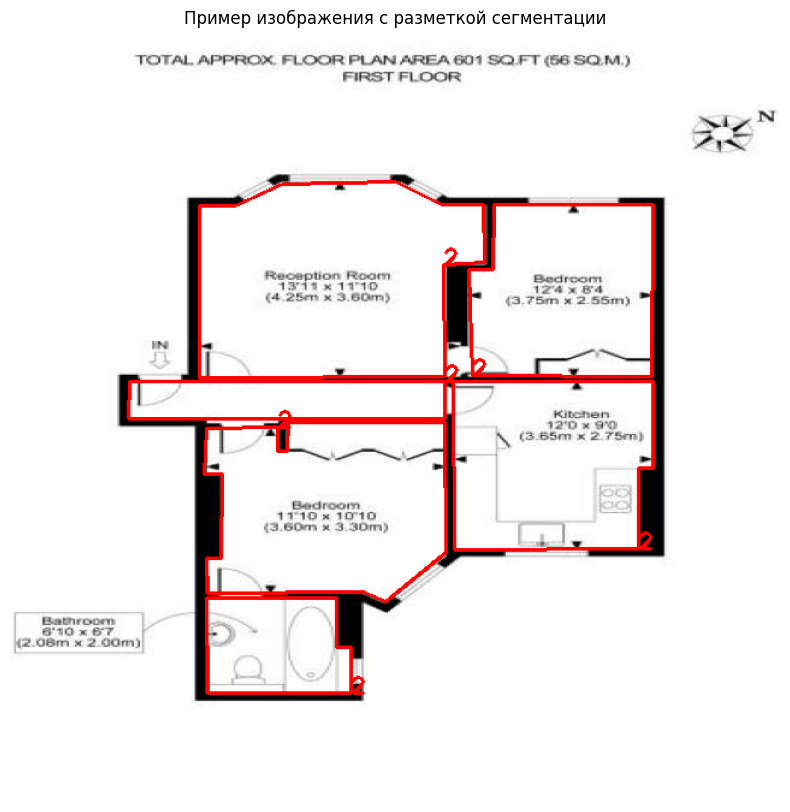

In [8]:
# Загружаем и аннотируем образец
image_path, label_path, sample_image_file = get_sample_paths(images_dir, labels_dir, 4)
image_rgb, annotations = load_image_and_annotations(image_path, label_path)
annotated_image = annotate_image(image_rgb, annotations)
display_image(annotated_image, "Пример изображения с разметкой сегментации")

## Обучение модели

Загрузим и обучим модель YOLO 11s-seg

In [ ]:
model = YOLO("yolo11s-seg.pt")
print("Начало обучения модели...")
results = model.train(
    data=yaml_file,
    epochs=50,
    imgsz=640,
    device="cuda",
    workers=0,
    batch=32,
    patience=10,
    project="seg_project",
    name="seg_model"
)
print("Обучение завершено.")

100%|██████████| 19.7M/19.7M [00:00<00:00, 184MB/s]


Начало обучения модели...
Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=0, project=seg_project, name=seg_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

100%|██████████| 755k/755k [00:00<00:00, 18.2MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/BigMerge-1/train/labels... 11529 images, 12 backgrounds, 0 corrupt: 100%|██████████| 11529/11529 [00:15<00:00, 728.34it/s]

train: WARNING ⚠️ /kaggle/working/BigMerge-1/train/images/2-Bedroom-Home-Plan-With-Dimensions_png.rf.e1fd7666a98f4aded8a7baf9c8685394.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/BigMerge-1/train/images/31883016_jpg.rf.222b2ec7711f94aad061d82e9e184f2e.jpg: 7 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/BigMerge-1/train/images/31883016_jpg.rf.7c2d14e425740b54b719828f4c633b1f.jpg: 7 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/BigMerge-1/train/images/31883016_jpg.rf.e0a656c791eb592ea503c9512219ff76.jpg: 7 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/BigMerge-1/train/images/3_jpg.rf.7d20e73a14c31aed7e8345e30c63370f.jpg: 16 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/BigMerge-1/train/images/3_jpg.rf.a8de6aa11ecb731c8ec15015257d9bdd.jpg: 16 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/BigMerge-1/train/images/3_jpg.rf.d319f19fc0f1d2b583e31cf9319378b2.jpg: 15 duplicate labels removed
train: WARNING ⚠️ 

train: New cache created: /kaggle/working/BigMerge-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /kaggle/working/BigMerge-1/valid/labels... 592 images, 0 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:00<00:00, 755.28it/s]


val: New cache created: /kaggle/working/BigMerge-1/valid/labels.cache
Plotting labels to seg_project/seg_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to seg_project/seg_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      13.1G     0.7992      1.441     0.8797       1.01        163        640: 100%|██████████| 361/361 [12:13<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

                   all        592       6464       0.43      0.479      0.379      0.262      0.428      0.444      0.374      0.226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50        13G     0.7304      1.225     0.6066     0.9619        195        640: 100%|██████████| 361/361 [12:20<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

                   all        592       6464       0.29      0.623      0.361      0.265      0.287      0.606      0.352       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      14.2G     0.7127       1.18     0.5789     0.9539        146        640: 100%|██████████| 361/361 [12:08<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

                   all        592       6464      0.613      0.375      0.384      0.272      0.599      0.365       0.37      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      15.2G      0.701      1.157     0.5621      0.949        199        640: 100%|██████████| 361/361 [12:07<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]

                   all        592       6464      0.338      0.542      0.339      0.248      0.334      0.453       0.33      0.204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50        15G     0.6729      1.089     0.5304     0.9365        213        640: 100%|██████████| 361/361 [12:06<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

                   all        592       6464      0.365      0.588      0.466       0.33      0.578       0.45       0.45      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      13.7G     0.6609      1.065       0.51     0.9308        198        640: 100%|██████████| 361/361 [12:15<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

                   all        592       6464      0.455      0.563       0.45      0.336      0.441      0.579       0.44      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      15.4G     0.6444      1.036     0.4958     0.9246        177        640: 100%|██████████| 361/361 [12:18<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]

                   all        592       6464      0.417      0.718      0.472      0.351      0.417       0.66      0.458      0.281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.1G     0.6274      1.001     0.4774     0.9183        289        640: 100%|██████████| 361/361 [12:19<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

                   all        592       6464       0.46      0.623      0.487      0.352      0.454      0.559      0.471      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      14.9G     0.6276     0.9919      0.467     0.9142        184        640: 100%|██████████| 361/361 [12:21<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]

                   all        592       6464      0.467      0.635      0.491      0.369      0.459      0.618      0.473      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      14.3G     0.6183     0.9748      0.458     0.9124        216        640: 100%|██████████| 361/361 [12:19<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]

                   all        592       6464      0.429      0.787      0.508      0.383      0.419      0.759      0.491      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.5G     0.6078     0.9476      0.451     0.9076        231        640: 100%|██████████| 361/361 [12:21<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]

                   all        592       6464      0.514      0.626      0.517      0.399      0.499      0.609      0.495      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      12.4G     0.6013     0.9444     0.4448     0.9058        146        640: 100%|██████████| 361/361 [12:24<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]

                   all        592       6464      0.494      0.636      0.506       0.38      0.484      0.612      0.497      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.8G     0.5998     0.9312     0.4363     0.9035        150        640: 100%|██████████| 361/361 [12:09<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

                   all        592       6464      0.409       0.68       0.45      0.347      0.436      0.535      0.428      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.8G     0.5931     0.9316      0.429     0.9011        191        640: 100%|██████████| 361/361 [12:13<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

                   all        592       6464      0.436      0.676      0.495      0.376      0.413      0.649      0.465      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      15.1G     0.5907     0.9151      0.424     0.8996        162        640: 100%|██████████| 361/361 [12:11<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]

                   all        592       6464      0.461      0.736      0.515      0.396      0.446      0.716      0.494      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      12.1G      0.583     0.9061     0.4181     0.8961        247        640: 100%|██████████| 361/361 [12:14<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]

                   all        592       6464      0.478      0.731      0.523      0.412      0.474      0.692      0.504      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      14.1G      0.573     0.8827     0.4137      0.893         94        640: 100%|██████████| 361/361 [12:09<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

                   all        592       6464      0.378      0.523      0.401      0.322      0.367      0.501      0.383      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      14.9G     0.5718     0.8875     0.4073     0.8925        319        640: 100%|██████████| 361/361 [12:03<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

                   all        592       6464      0.484      0.704      0.519      0.403       0.47      0.683      0.491      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      14.6G     0.5633     0.8702     0.4021     0.8892        189        640: 100%|██████████| 361/361 [12:06<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

                   all        592       6464       0.46      0.572      0.499      0.399      0.463       0.56       0.48      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      14.6G     0.5593     0.8734     0.3994     0.8889        169        640: 100%|██████████| 361/361 [12:07<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

                   all        592       6464      0.462      0.726      0.519      0.419      0.496      0.616      0.502      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      14.4G     0.5575     0.8504     0.3923     0.8862        224        640: 100%|██████████| 361/361 [12:11<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]

                   all        592       6464      0.465      0.624      0.481      0.384      0.451      0.607      0.466      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.7G     0.5542     0.8515     0.3913     0.8854        284        640: 100%|██████████| 361/361 [12:13<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]

                   all        592       6464       0.48      0.591       0.52      0.415      0.467      0.576      0.502      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      14.5G     0.5506     0.8475     0.3869     0.8836        125        640: 100%|██████████| 361/361 [12:19<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]

                   all        592       6464      0.516      0.594      0.538      0.429       0.51      0.568      0.511      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      15.3G     0.5453     0.8402      0.383     0.8825        171        640: 100%|██████████| 361/361 [12:06<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

                   all        592       6464      0.531      0.673      0.552       0.44      0.506      0.625      0.522      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      15.3G     0.5412     0.8301     0.3779     0.8811        221        640: 100%|██████████| 361/361 [12:12<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

                   all        592       6464      0.513        0.6      0.531      0.432      0.506      0.571      0.513      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.1G     0.5304     0.8115     0.3698     0.8775        120        640: 100%|██████████| 361/361 [12:10<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

                   all        592       6464      0.539      0.636       0.54      0.438      0.519      0.589      0.515      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      13.3G     0.5328     0.8117     0.3707     0.8777        168        640: 100%|██████████| 361/361 [12:08<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]

                   all        592       6464      0.486      0.749      0.524      0.419      0.469      0.711      0.493      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      14.7G     0.5317     0.8056     0.3675     0.8759        318        640: 100%|██████████| 361/361 [12:13<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

                   all        592       6464      0.516      0.688      0.545      0.439      0.496      0.669      0.515      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      12.9G     0.5264     0.8035     0.3631     0.8733        192        640: 100%|██████████| 361/361 [12:11<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]

                   all        592       6464       0.54      0.579      0.544      0.442       0.52      0.563      0.512       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      15.6G      0.525     0.7969     0.3629     0.8734        337        640: 100%|██████████| 361/361 [12:10<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

                   all        592       6464      0.489      0.673      0.532      0.434      0.473      0.675      0.507      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50        13G     0.5163      0.788     0.3572      0.872        258        640: 100%|██████████| 361/361 [12:12<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]

                   all        592       6464      0.533      0.561       0.54      0.441      0.524      0.547      0.518      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      14.8G     0.5132     0.7848      0.355     0.8709        201        640: 100%|██████████| 361/361 [12:04<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

                   all        592       6464      0.519      0.652      0.534      0.434      0.486      0.671      0.509      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50        13G     0.5098     0.7801       0.35     0.8698        300        640: 100%|██████████| 361/361 [12:16<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]

                   all        592       6464      0.522       0.67      0.537      0.433      0.506      0.652      0.513      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      14.8G      0.508     0.7667     0.3486     0.8686        216        640: 100%|██████████| 361/361 [12:11<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

                   all        592       6464      0.517      0.675      0.539       0.44        0.5      0.656      0.516      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      15.4G     0.5018      0.757     0.3437     0.8671         99        640: 100%|██████████| 361/361 [12:10<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]

                   all        592       6464      0.526        0.6      0.539       0.44      0.524      0.574      0.514      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      13.6G     0.5006     0.7635     0.3434     0.8671        324        640: 100%|██████████| 361/361 [12:19<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

                   all        592       6464      0.557      0.601      0.557      0.451      0.539      0.587      0.535      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.1G     0.4968     0.7488     0.3392     0.8651        168        640: 100%|██████████| 361/361 [12:23<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

                   all        592       6464      0.519      0.674      0.547      0.446      0.496      0.649      0.517      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.1G     0.4968     0.7496     0.3376     0.8645        186        640: 100%|██████████| 361/361 [12:10<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

                   all        592       6464      0.505      0.662      0.551      0.451      0.488      0.639      0.524      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      13.8G     0.4924     0.7485     0.3347     0.8645        235        640: 100%|██████████| 361/361 [12:13<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]

                   all        592       6464      0.531      0.587      0.541      0.442      0.519      0.573      0.524      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50        14G     0.4892     0.7398     0.3315     0.8624        162        640: 100%|██████████| 361/361 [12:16<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

                   all        592       6464      0.528      0.656      0.552      0.451      0.516      0.632      0.536      0.352


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      11.6G      0.468     0.7118       0.29       0.84        103        640: 100%|██████████| 361/361 [09:48<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]

                   all        592       6464      0.523      0.646      0.553      0.451      0.507      0.626       0.52      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      12.2G     0.4647     0.7093      0.285     0.8383         83        640: 100%|██████████| 361/361 [09:45<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

                   all        592       6464      0.538      0.646      0.546      0.449      0.521      0.646      0.521      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.1G     0.4574     0.6959     0.2803     0.8369         74        640: 100%|██████████| 361/361 [09:37<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

                   all        592       6464      0.517      0.681      0.552       0.45      0.491      0.654      0.517       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50        12G     0.4563     0.6981     0.2792     0.8359        112        640: 100%|██████████| 361/361 [09:45<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]

                   all        592       6464      0.516      0.673      0.543      0.443      0.487      0.666      0.517       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      12.7G     0.4486     0.6836     0.2747      0.835        164        640: 100%|██████████| 361/361 [09:38<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

                   all        592       6464      0.517      0.658      0.531      0.438      0.489      0.666      0.501      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.6G     0.4436     0.6727     0.2716     0.8325        132        640: 100%|██████████| 361/361 [09:45<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]

                   all        592       6464      0.503      0.684      0.535      0.438      0.473      0.653      0.497      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.9G     0.4391     0.6688     0.2691     0.8314         81        640: 100%|██████████| 361/361 [09:40<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

                   all        592       6464       0.52      0.681      0.537      0.441      0.485      0.651      0.496      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.7G     0.4359     0.6643     0.2666     0.8292        143        640: 100%|██████████| 361/361 [09:39<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

                   all        592       6464      0.509       0.68      0.537      0.446      0.488      0.658      0.505      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.1G     0.4326     0.6556     0.2635     0.8304         63        640: 100%|██████████| 361/361 [09:45<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]

                   all        592       6464      0.511      0.681      0.537      0.442      0.479      0.653        0.5      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      12.4G     0.4302     0.6546     0.2598     0.8284        130        640: 100%|██████████| 361/361 [09:40<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]

                   all        592       6464      0.517      0.684      0.538      0.446      0.491      0.657      0.508      0.338
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



50 epochs completed in 9.995 hours.
Optimizer stripped from seg_project/seg_model/weights/last.pt, 20.5MB
Optimizer stripped from seg_project/seg_model/weights/best.pt, 20.5MB

Validating seg_project/seg_model/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,068,364 parameters, 0 gradients, 35.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


                   all        592       6464      0.529      0.656      0.553      0.451      0.516      0.633      0.537      0.352
       buildingoutline         20         20     0.0407       0.35      0.132      0.118     0.0346        0.3      0.127     0.0545
                  door         17        123      0.592      0.724       0.63      0.469      0.585      0.715      0.616      0.353
                  room        592       6234      0.887      0.955      0.953      0.875      0.884      0.951      0.954      0.771
                window         17         87      0.596      0.598      0.497      0.342      0.559      0.563      0.451       0.23


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 6.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to seg_project/seg_model
Обучение завершено.


Начало предсказания для файла: /content/Building-Floor-Plans-1/test/images/47534687_jpg.rf.2a7392880357ee697c900c0c2f441ddf.jpg

image 1/1 /content/Building-Floor-Plans-1/test/images/47534687_jpg.rf.2a7392880357ee697c900c0c2f441ddf.jpg: 640x640 10 rooms, 1435.1ms
Speed: 9.2ms preprocess, 1435.1ms inference, 103.3ms postprocess per image at shape (1, 3, 640, 640)


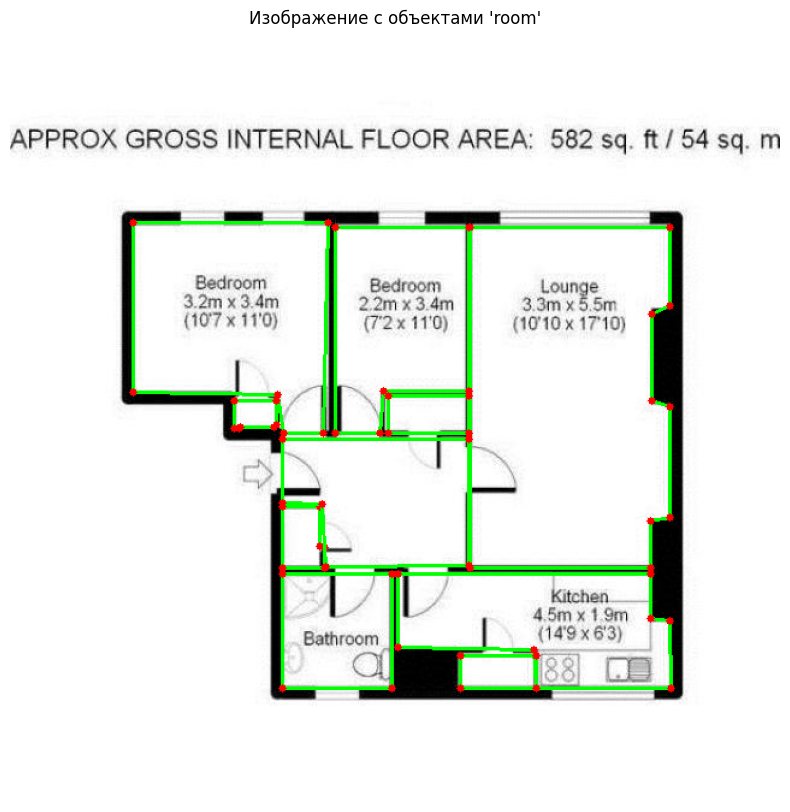

Список координат для файла /content/Building-Floor-Plans-1/test/images/47534687_jpg.rf.2a7392880357ee697c900c0c2f441ddf.jpg:
Объект 1: Класс: 2
Координаты точек:
(102.0, 158.0)
(102.0, 299.0)
(222.0, 301.0)
(227.0, 333.0)
(260.0, 333.0)
(264.0, 158.0)
------------------------------
Объект 2: Класс: 2
Координаты точек:
(382.0, 162.0)
(382.0, 445.0)
(532.0, 445.0)
(532.0, 406.0)
(548.0, 403.0)
(548.0, 311.0)
(533.0, 306.0)
(533.0, 234.0)
(548.0, 227.0)
(548.0, 162.0)
------------------------------
Объект 3: Класс: 2
Координаты точек:
(226.0, 450.0)
(226.0, 545.0)
(317.0, 545.0)
(317.0, 450.0)
------------------------------
Объект 4: Класс: 2
Координаты точек:
(322.0, 450.0)
(322.0, 511.0)
(435.0, 513.0)
(437.0, 545.0)
(549.0, 545.0)
(548.0, 489.0)
(532.0, 487.0)
(532.0, 450.0)
------------------------------
Объект 5: Класс: 2
Координаты точек:
(270.0, 162.0)
(270.0, 333.0)
(307.0, 333.0)
(310.0, 298.0)
(381.0, 298.0)
(381.0, 162.0)
------------------------------
Объект 6: Класс: 2
Коорди

In [ ]:
# Предсказание на тестовых данных
test_path = os.path.join(dataset.location, "test", "images")
test_files = sorted(glob.glob(os.path.join(test_path, "*.*")))
if not test_files:
    print("Ошибка: нет изображений в тестовой папке.")
else:
    selected_file = test_files[100]
    print(f"Начало предсказания для файла: {selected_file}")
    pred_results = list(model.predict(source=selected_file, imgsz=640))
    if not pred_results:
        print("Ошибка: предсказания не получены.")
    else:
        pred = pred_results[0]
        process_and_display_prediction(pred, selected_file)

## Загружаем модель (YOLO12s-seg)

In [9]:
model12 = YOLO(os.path.join(PATH, "bestYOLO12s.pt"))

Начало предсказания для файла: /content/Building-Floor-Plans-1/test/images/47534687_jpg.rf.2a7392880357ee697c900c0c2f441ddf.jpg

image 1/1 /content/Building-Floor-Plans-1/test/images/47534687_jpg.rf.2a7392880357ee697c900c0c2f441ddf.jpg: 640x640 10 rooms, 1466.7ms
Speed: 18.0ms preprocess, 1466.7ms inference, 77.9ms postprocess per image at shape (1, 3, 640, 640)


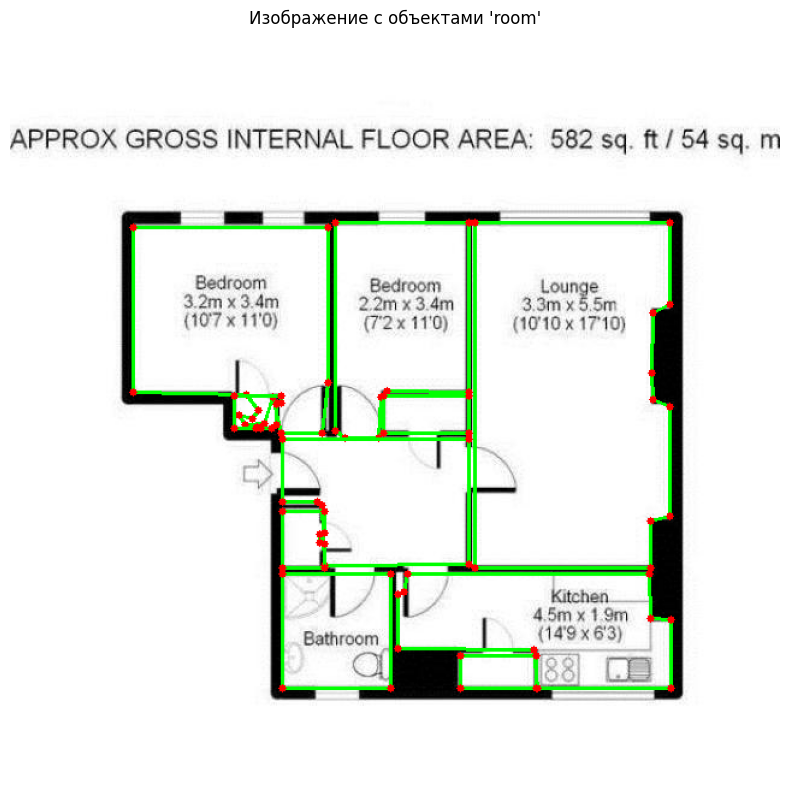

Список координат для файла /content/Building-Floor-Plans-1/test/images/47534687_jpg.rf.2a7392880357ee697c900c0c2f441ddf.jpg:
Объект 1: Класс: 2
Координаты точек:
(102.0, 162.0)
(102.0, 299.0)
(196.0, 301.0)
(206.0, 314.0)
(201.0, 321.0)
(190.0, 318.0)
(195.0, 326.0)
(211.0, 325.0)
(218.0, 303.0)
(225.0, 333.0)
(259.0, 333.0)
(264.0, 291.0)
(264.0, 162.0)
------------------------------
Объект 2: Класс: 2
Координаты точек:
(386.0, 158.0)
(386.0, 445.0)
(532.0, 445.0)
(532.0, 406.0)
(548.0, 402.0)
(548.0, 311.0)
(534.0, 305.0)
(533.0, 283.0)
(534.0, 233.0)
(548.0, 226.0)
(548.0, 158.0)
------------------------------
Объект 3: Класс: 2
Координаты точек:
(381.0, 158.0)
(270.0, 158.0)
(270.0, 331.0)
(278.0, 337.0)
(306.0, 337.0)
(308.0, 303.0)
(313.0, 298.0)
(381.0, 299.0)
------------------------------
Объект 4: Класс: 2
Координаты точек:
(226.0, 338.0)
(226.0, 390.0)
(255.0, 390.0)
(259.0, 393.0)
(261.0, 443.0)
(381.0, 442.0)
(381.0, 338.0)
------------------------------
Объект 5: Класс: 2

In [10]:
# Предсказание на тестовых данных
test_path = os.path.join(dataset.location, "test", "images")
test_files = sorted(glob.glob(os.path.join(test_path, "*.*")))
if not test_files:
    print("Ошибка: нет изображений в тестовой папке.")
else:
    selected_file = test_files[100]
    print(f"Начало предсказания для файла: {selected_file}")
    pred_results = list(model12.predict(source=selected_file, imgsz=640))
    if not pred_results:
        print("Ошибка: предсказания не получены.")
    else:
        pred = pred_results[0]
        process_and_display_prediction(pred, selected_file)

## Загружаем модель (YOLOv8s-seg)

In [11]:
model8 = YOLO(os.path.join(PATH, "bestYOLO8s.pt"))

Начало предсказания для файла: /content/Building-Floor-Plans-1/test/images/47534687_jpg.rf.2a7392880357ee697c900c0c2f441ddf.jpg

image 1/1 /content/Building-Floor-Plans-1/test/images/47534687_jpg.rf.2a7392880357ee697c900c0c2f441ddf.jpg: 640x640 9 rooms, 939.9ms
Speed: 4.0ms preprocess, 939.9ms inference, 34.5ms postprocess per image at shape (1, 3, 640, 640)


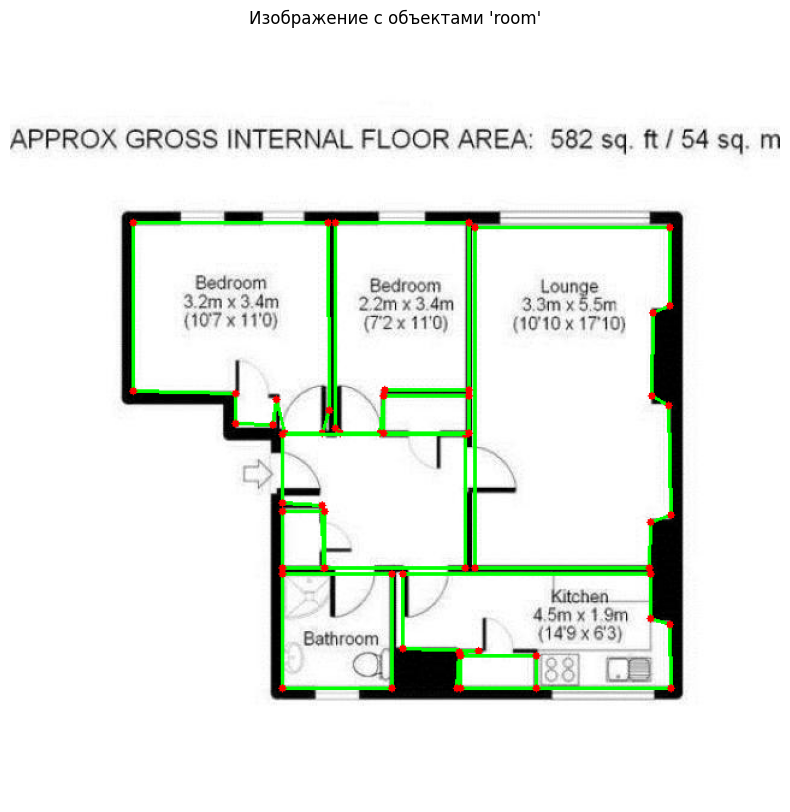

Список координат для файла /content/Building-Floor-Plans-1/test/images/47534687_jpg.rf.2a7392880357ee697c900c0c2f441ddf.jpg:
Объект 1: Класс: 2
Координаты точек:
(102.0, 158.0)
(102.0, 298.0)
(187.0, 300.0)
(187.0, 325.0)
(218.0, 326.0)
(221.0, 305.0)
(228.0, 333.0)
(259.0, 333.0)
(265.0, 314.0)
(264.0, 158.0)
------------------------------
Объект 2: Класс: 2
Координаты точек:
(381.0, 158.0)
(270.0, 158.0)
(270.0, 329.0)
(274.0, 333.0)
(307.0, 333.0)
(311.0, 297.0)
(381.0, 297.0)
------------------------------
Объект 3: Класс: 2
Координаты точек:
(226.0, 450.0)
(226.0, 545.0)
(317.0, 545.0)
(317.0, 450.0)
------------------------------
Объект 4: Класс: 2
Координаты точек:
(386.0, 162.0)
(386.0, 445.0)
(531.0, 445.0)
(532.0, 407.0)
(549.0, 401.0)
(547.0, 310.0)
(533.0, 302.0)
(534.0, 233.0)
(548.0, 227.0)
(548.0, 162.0)
------------------------------
Объект 5: Класс: 2
Координаты точек:
(226.0, 334.0)
(226.0, 391.0)
(259.0, 393.0)
(260.0, 445.0)
(378.0, 445.0)
(378.0, 334.0)
-----------

In [12]:
# Предсказание на тестовых данных
test_path = os.path.join(dataset.location, "test", "images")
test_files = sorted(glob.glob(os.path.join(test_path, "*.*")))
if not test_files:
    print("Ошибка: нет изображений в тестовой папке.")
else:
    selected_file = test_files[100]
    print(f"Начало предсказания для файла: {selected_file}")
    pred_results = list(model8.predict(source=selected_file, imgsz=640))
    if not pred_results:
        print("Ошибка: предсказания не получены.")
    else:
        pred = pred_results[0]
        process_and_display_prediction(pred, selected_file)

В ходе работы были обучены модели YOLOv8s-seg, YOLO11n-seg, YOLO11s-seg и YOLO12s-seg, они все показали схожий результат, но лучшей оказалась YOLO11s-seg.